# RDD2022 - Exploratory Data Analysis (EDA)

This notebook provides a set of tools to analyze and visualize the RDD2022 road damage dataset. You can calculate class distributions and view random annotated samples from the `train`, `val`, or `test` sets.

In [7]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Configuration

Update the variables in the next cell to point to your dataset directory and to select which data subset (`train`, `val`, or `test`) you want to analyze.

In [8]:
# SET THE BASE PATH TO YOUR DATASET
BASE_DATASET_DIR = r"C:\Users\risho\Documents\RoadSense\config\rdd2022"

# CHOOSE WHICH DATA SUBSET TO ANALYZE: 'train', 'val', or 'test'
SUBSET_TO_ANALYZE = 'train'

## Class Definitions and Colors

Here, we define the class names for the RDD2022 dataset and generate a unique color for each class for better visualizations.

In [9]:
CLASS_NAMES = {
    0: "D00 (Longitudinal Crack)",
    1: "D10 (Transverse Crack)",
    2: "D20 (Alligator Crack)",
    3: "D40 (Pothole)"
}

# Generate a color palette for visualizations
CLASS_COLORS = sns.color_palette("husl", len(CLASS_NAMES))
CLASS_COLORS = [(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in CLASS_COLORS]

## Helper and Analysis Functions

These are the core functions that will load annotations, calculate statistics, and display images. Run this cell to make the functions available for use in the cells below.

In [10]:
def load_labels(label_path, img_w, img_h):
    """Load YOLO annotations and convert to pixel bounding boxes."""
    boxes = []
    if not os.path.exists(label_path):
        return boxes

    with open(label_path, "r") as f:
        for line in f.readlines():
            try:
                cls, x_c, y_c, w, h = map(float, line.strip().split())
                cls = int(cls)

                # Convert from YOLO format (0-1) to pixel coordinates
                x1 = int((x_c - w / 2) * img_w)
                y1 = int((y_c - h / 2) * img_h)
                x2 = int((x_c + w / 2) * img_w)
                y2 = int((y_c + h / 2) * img_h)

                boxes.append((cls, x1, y1, x2, y2))
            except ValueError:
                print(f"Warning: Skipping malformed line in {label_path}")
    return boxes

def show_random_samples(subset='train', n=5):
    """Displays random images with their bounding boxes."""
    print(f"\nShowing {n} random samples from the '{subset}' set...")
    img_dir = os.path.join(BASE_DATASET_DIR, subset, "images")
    lbl_dir = os.path.join(BASE_DATASET_DIR, subset, "labels")

    if not os.path.exists(img_dir):
        print(f"Error: Image directory not found at {img_dir}")
        return

    img_files = os.listdir(img_dir)
    if len(img_files) < n:
        print(f"Warning: Requested {n} samples, but only {len(img_files)} images found.")
        n = len(img_files)
        
    chosen_files = random.sample(img_files, n)

    for file in chosen_files:
        img_path = os.path.join(img_dir, file)
        lbl_path = os.path.join(lbl_dir, os.path.splitext(file)[0] + ".txt")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        boxes = load_labels(lbl_path, w, h)

        # Draw boxes on the image
        for cls, x1, y1, x2, y2 in boxes:
            color = CLASS_COLORS[cls]
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, CLASS_NAMES.get(cls, "Unknown"), (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(f"Image: {file} (from '{subset}' set)")
        plt.axis("off")
        plt.show()
        
def dataset_stats(subset='train'):
    """Calculates and displays statistics for a given dataset subset."""
    print(f"\nCalculating statistics for the '{subset}' set...")
    img_dir = os.path.join(BASE_DATASET_DIR, subset, "images")
    lbl_dir = os.path.join(BASE_DATASET_DIR, subset, "labels")

    if not os.path.exists(lbl_dir):
        print(f"Error: Label directory not found at {lbl_dir}")
        return

    stats = {cls: 0 for cls in CLASS_NAMES}
    total_annotations = 0

    # Use tqdm for a progress bar
    for lbl_file in tqdm(os.listdir(lbl_dir), desc=f"Analyzing '{subset}' labels"):
        with open(os.path.join(lbl_dir, lbl_file), "r") as f:
            for line in f.readlines():
                try:
                    cls = int(line.split()[0])
                    if cls in stats:
                        stats[cls] += 1
                    total_annotations += 1
                except (ValueError, IndexError):
                    print(f"Warning: Skipping malformed line in {lbl_file}")

    df = pd.DataFrame({
        "Class Name": [CLASS_NAMES[c] for c in stats.keys()],
        "Annotation Count": list(stats.values())
    }).sort_values(by="Annotation Count", ascending=False)

    print("\n--- Dataset Statistics ---")
    print(f"Subset: {subset}")
    print(f"Total Images: {len(os.listdir(img_dir))}")
    print(f"Total Annotations (Bounding Boxes): {total_annotations}")
    print("Annotation Count by Class:")
    print(df.to_string(index=False))
    print("--------------------------\n")

    # Plot the class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Annotation Count", y="Class Name", data=df, palette="viridis")
    plt.title(f"Class Distribution in '{subset}' Set")
    plt.xlabel("Number of Annotations")
    plt.ylabel("Damage Type")
    plt.tight_layout()
    plt.show()

## Run Analysis

Now, let's run the analysis on the subset you configured earlier.


Calculating statistics for the 'train' set...


Analyzing 'train' labels: 100%|██████████| 26869/26869 [02:07<00:00, 210.35it/s]



--- Dataset Statistics ---
Subset: train
Total Images: 26869
Total Annotations (Bounding Boxes): 46296
Annotation Count by Class:
              Class Name  Annotation Count
D00 (Longitudinal Crack)             18201
  D10 (Transverse Crack)              8386
           D40 (Pothole)              7554
   D20 (Alligator Crack)              7527
--------------------------



C:\Users\risho\AppData\Local\Temp\ipykernel_9204\3387441022.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Annotation Count", y="Class Name", data=df, palette="viridis")


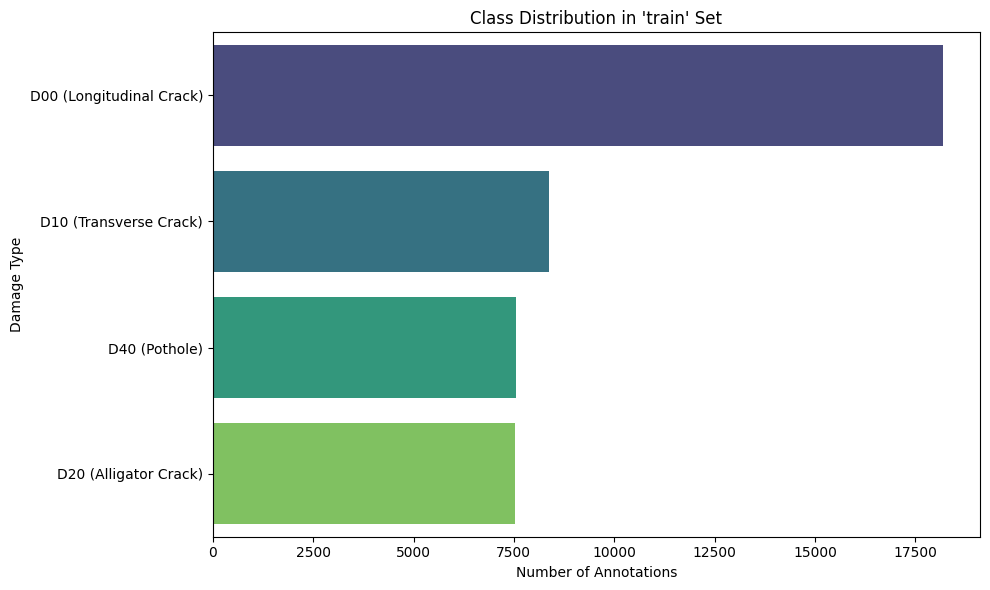

In [11]:
# Check that the base path exists before running analysis
if not os.path.exists(BASE_DATASET_DIR):
    print(f"FATAL ERROR: Base directory not found at '{BASE_DATASET_DIR}'")
    print("Please update the 'BASE_DATASET_DIR' variable in the configuration cell.")
else:
    # Run the statistics function
    dataset_stats(subset=SUBSET_TO_ANALYZE)

## Show Visual Samples

Finally, let's visualize some random samples from the dataset to sanity-check the annotations.


Showing 5 random samples from the 'train' set...


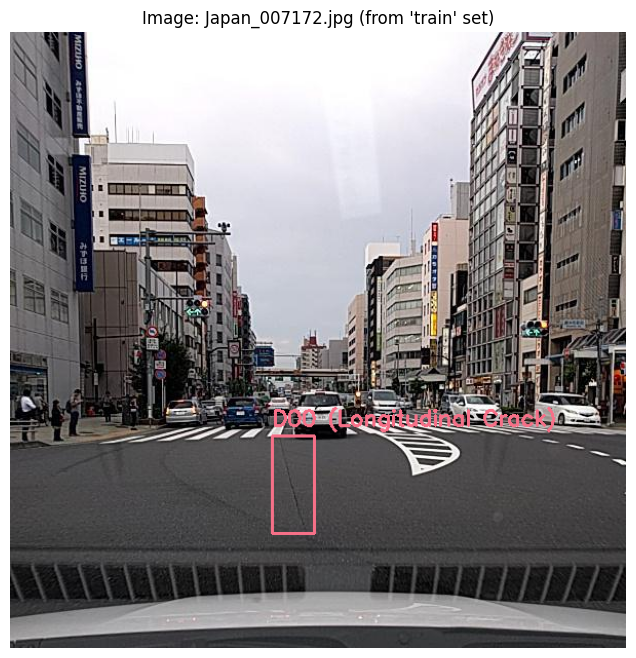

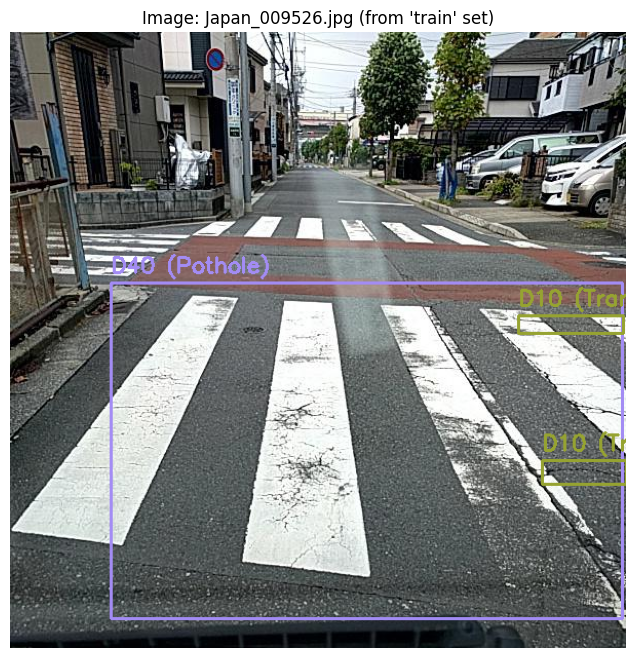

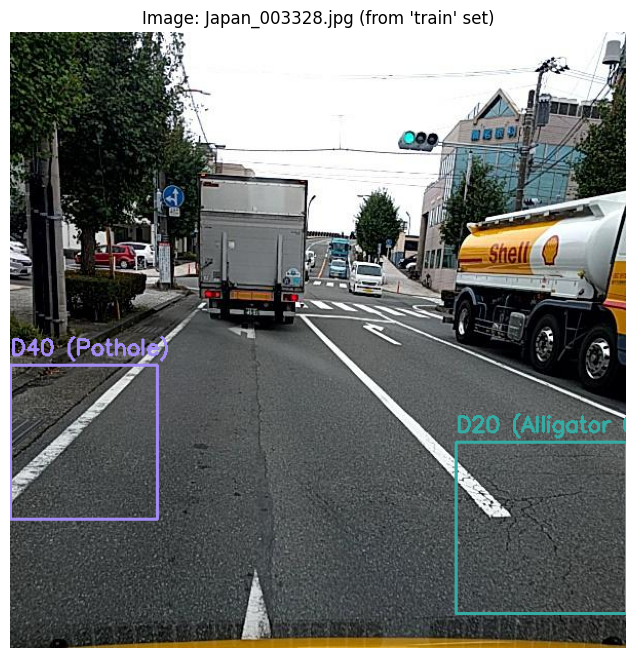

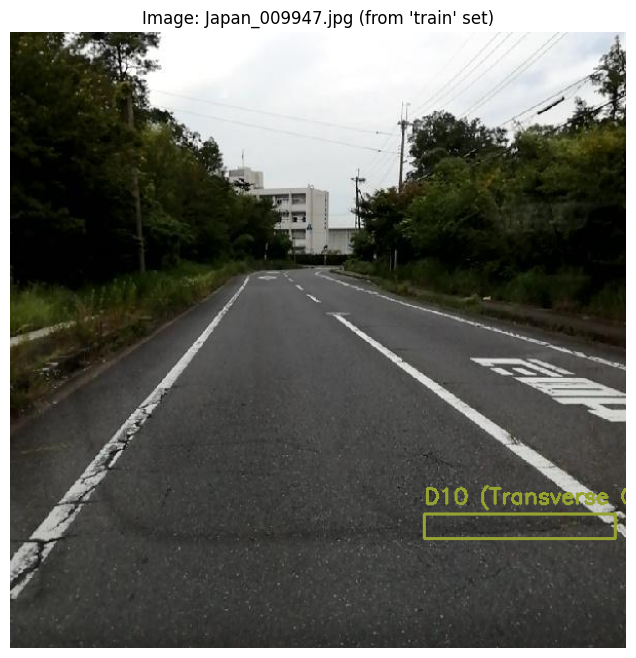

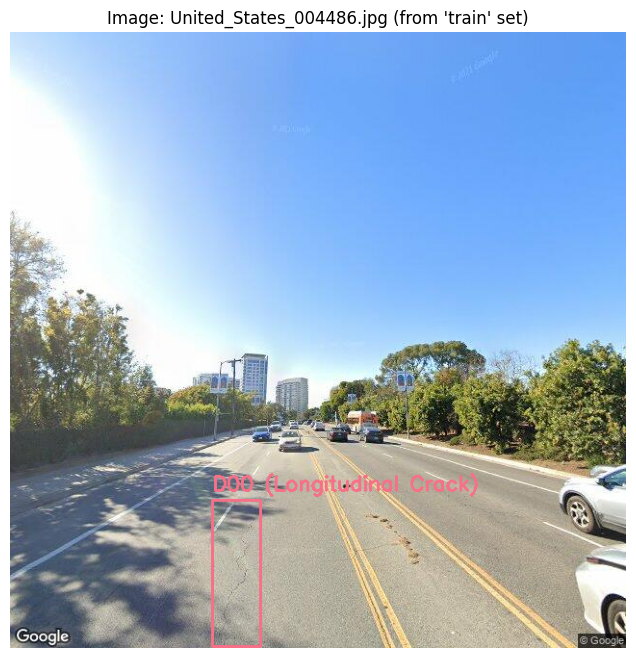

In [12]:
# Show 5 random samples
show_random_samples(subset=SUBSET_TO_ANALYZE, n=5)